In [6]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.cluster import KMeans

##############################
# Step 1: Load & Prepare Data
##############################

# Replace 'your_data.csv' with your actual CSV file path
df = pd.read_csv('../data/data_ilr_transformed/combined_data__resid_with_time.csv')

# Ensure data is sorted by ID and time
df = df.sort_values(by=['ID', 'time'])

# Group by ID and convert each group into a sequence array [T, 3]
grouped = df.groupby('ID')
sequences = []
lengths = []

for pid, group in grouped:
    # Extract ilr1, ilr2, ilr3 into a numpy array
    seq = group[['ilr1_residual', 'ilr2_residual', 'ilr3_residual']].values
    sequences.append(seq)
    lengths.append(len(seq))

# Find max length
max_length = max(lengths)

# Pad sequences to max_length with zeros
padded_sequences = []
for seq in sequences:
    T = len(seq)
    if T < max_length:
        pad_width = max_length - T
        # Pad at the end
        padded_seq = np.concatenate([seq, np.zeros((pad_width, 3))], axis=0)
    else:
        padded_seq = seq
    padded_sequences.append(padded_seq)

padded_sequences = np.stack(padded_sequences, axis=0)  # [N, max_length, 3]
lengths = np.array(lengths)

##############################
# Step 2: Create a Dataset
##############################

class RadicalizationDataset(Dataset):
    def __init__(self, data, lengths):
        # data: np array [N, T, 3]
        # lengths: np array [N]
        self.data = torch.from_numpy(data).float()
        self.lengths = lengths

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.lengths[idx]

dataset = RadicalizationDataset(padded_sequences, lengths)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

##############################
# Step 3: Define LSTM Autoencoder
##############################

class Encoder(nn.Module):
    def __init__(self, input_size=3, hidden_size=32, latent_size=16, num_layers=1):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, latent_size)

    def forward(self, x, lengths):
        # x: [batch, T, input_size]
        # lengths: [batch]
        # For variable lengths, use pack_padded_sequence:
        # Sort by length (descending) to use pack_padded_sequence if needed
        sorted_lengths, indices = torch.sort(lengths, descending=True)
        x_sorted = x[indices]

        packed = nn.utils.rnn.pack_padded_sequence(x_sorted, sorted_lengths.cpu(), batch_first=True, enforce_sorted=True)
        _, (h, c) = self.lstm(packed)
        # h: [num_layers, batch, hidden_size]
        h = h[-1]  # take last layer
        # Unsort h back to original order
        _, desort_indices = torch.sort(indices)
        h = h[desort_indices]

        latent = self.fc(h) # [batch, latent_size]
        return latent

class Decoder(nn.Module):
    def __init__(self, latent_size=16, hidden_size=32, output_size=3, num_layers=1, max_length=15):
        super().__init__()
        self.latent_to_hidden = nn.Linear(latent_size, hidden_size)
        self.lstm = nn.LSTM(output_size, hidden_size, num_layers, batch_first=True)
        self.output_layer = nn.Linear(hidden_size, output_size)
        self.max_length = max_length

    def forward(self, latent):
        batch_size = latent.size(0)
        hidden = self.latent_to_hidden(latent).unsqueeze(0)  # [1, batch, hidden_size]
        cell = torch.zeros_like(hidden) # [1, batch, hidden_size]

        # Use zero as input at each timestep
        inputs = torch.zeros(batch_size, self.max_length, 3, device=latent.device)
        output, (h, c) = self.lstm(inputs, (hidden, cell))
        reconstruction = self.output_layer(output) # [batch, T, 3]
        return reconstruction

class LSTMAutoencoder(nn.Module):
    def __init__(self, input_size=3, hidden_size=32, latent_size=16, num_layers=1, max_length=15):
        super().__init__()
        self.encoder = Encoder(input_size, hidden_size, latent_size, num_layers)
        self.decoder = Decoder(latent_size, hidden_size, input_size, num_layers, max_length)

    def forward(self, x, lengths):
        latent = self.encoder(x, lengths)
        reconstruction = self.decoder(latent)
        return reconstruction, latent

##############################
# Step 4: Train the Model
##############################

def train_autoencoder(model, dataloader, epochs=100, lr=1e-3, device='cpu'):
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    model.train()
    for epoch in range(epochs):
        total_loss = 0.0
        for batch_x, batch_len in dataloader:
            batch_x, batch_len = batch_x.to(device), batch_len.to(device)
            reconstruction, _ = model(batch_x, batch_len)
            loss = criterion(reconstruction, batch_x)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * batch_x.size(0)
        
        avg_loss = total_loss / len(dataloader.dataset)
        print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")

    return model

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = LSTMAutoencoder(input_size=3, hidden_size=32, latent_size=16, num_layers=1, max_length=max_length)
trained_model = train_autoencoder(model, dataloader, epochs=100, lr=1e-3, device=device)

##############################
# Step 5: Extract Embeddings & Cluster
##############################

embeddings = []
trained_model.eval()
with torch.no_grad():
    for batch_x, batch_len in DataLoader(dataset, batch_size=32):
        batch_x, batch_len = batch_x.to(device), batch_len.to(device)
        _, latent = trained_model(batch_x, batch_len)
        embeddings.append(latent.cpu().numpy())

embeddings = np.concatenate(embeddings, axis=0) # [N, latent_size]

# Perform K-Means clustering
kmeans = KMeans(n_clusters=3, random_state=42)
cluster_labels = kmeans.fit_predict(embeddings)

print("Cluster assignments:", cluster_labels)

Epoch 1/100, Loss: 2.2826
Epoch 2/100, Loss: 2.0876
Epoch 3/100, Loss: 1.9983
Epoch 4/100, Loss: 1.9435
Epoch 5/100, Loss: 1.8904
Epoch 6/100, Loss: 1.8397
Epoch 7/100, Loss: 1.8041
Epoch 8/100, Loss: 1.7844
Epoch 9/100, Loss: 1.7657
Epoch 10/100, Loss: 1.7514
Epoch 11/100, Loss: 1.7410
Epoch 12/100, Loss: 1.7314
Epoch 13/100, Loss: 1.7235
Epoch 14/100, Loss: 1.7078
Epoch 15/100, Loss: 1.7030
Epoch 16/100, Loss: 1.6907
Epoch 17/100, Loss: 1.6776
Epoch 18/100, Loss: 1.6652
Epoch 19/100, Loss: 1.6610
Epoch 20/100, Loss: 1.6532
Epoch 21/100, Loss: 1.6349
Epoch 22/100, Loss: 1.6341
Epoch 23/100, Loss: 1.6262
Epoch 24/100, Loss: 1.6213
Epoch 25/100, Loss: 1.6162
Epoch 26/100, Loss: 1.6121
Epoch 27/100, Loss: 1.6062
Epoch 28/100, Loss: 1.6110
Epoch 29/100, Loss: 1.5989
Epoch 30/100, Loss: 1.5937
Epoch 31/100, Loss: 1.5982
Epoch 32/100, Loss: 1.5881
Epoch 33/100, Loss: 1.5848
Epoch 34/100, Loss: 1.5817
Epoch 35/100, Loss: 1.5824
Epoch 36/100, Loss: 1.5780
Epoch 37/100, Loss: 1.5722
Epoch 38/1

In [7]:
# Assuming `embeddings` and `cluster_labels` are aligned with the unique IDs in the original data
# Get unique IDs in the same order as the embeddings were processed
unique_ids = df['ID'].unique()

# Create a mapping of ID to cluster label
id_to_cluster = dict(zip(unique_ids, cluster_labels))

# Assign cluster labels back to the original dataset
df['cluster'] = df['ID'].map(id_to_cluster)

# Now `df` has a new column 'cluster' with the cluster assignment for each participant

In [25]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

##############################
# Step 1: Load & Prepare Data
##############################

df = pd.read_csv("../data/data_ilr_transformed/combined_data.csv")
print(f"Combined dataset shape: {df.shape}")

# Variables
ilr_columns = ['ilr1', 'ilr2', 'ilr3']
control_columns = ['excluded', 'injustice', 'personal', 'violence']
covariate_columns = ['gender', 'age', 'condition']
ilr_resid_columns = ['ilr1_residual', 'ilr2_residual', 'ilr3_residual']

# Drop rows with NAs in covariates and standardize age
for covariate in covariate_columns:
    df = df[df[covariate].notna()]

df[['age']] = StandardScaler().fit_transform(df[['age']])

##### Feature Engineering #####
# Relative time
df['relative_time'] = df.groupby('ID')['time'].transform(lambda x: x / x.max())

# Calculate mean, std, min, max per participant
for col in ilr_resid_columns:
    df[f'{col}_mean'] = df.groupby('ID')[col].transform('mean')
    df[f'{col}_std'] = df.groupby('ID')[col].transform('std')
    df[f'{col}_min'] = df.groupby('ID')[col].transform('min')
    df[f'{col}_max'] = df.groupby('ID')[col].transform('max')

# Moving Average and EMA
window_size = 2
for col in ilr_resid_columns:
    df[f'{col}_moving_avg'] = df.groupby('ID')[col].transform(lambda x: x.rolling(window=window_size, min_periods=1).mean())
    df[f'{col}_ema'] = df.groupby('ID')[col].transform(lambda x: x.ewm(span=window_size, adjust=False).mean())

ilr_moving_avg_cols = ['ilr1_residual_moving_avg', 'ilr2_residual_moving_avg', 'ilr3_residual_moving_avg']
ilr_ema_cols = ['ilr1_residual_ema', 'ilr2_residual_ema', 'ilr3_residual_ema']

# Fourier transformation
fourier_components = 2
for column_group in [ilr_moving_avg_cols, ilr_ema_cols]:
    for col in column_group:
        def compute_fourier(x):
            fft_vals = np.fft.fft(x)
            # Retain only the first N components (real and imaginary)
            return np.hstack([fft_vals.real[:fourier_components], fft_vals.imag[:fourier_components]])

        fourier_df = (
            df.groupby('ID')[col]
            .apply(lambda x: compute_fourier(x.values))
            .apply(pd.Series)
            .rename(columns=lambda i: f'{col}_fourier_{i+1}')
        )
        df = df.join(fourier_df, on='ID')

# Define feature columns
feature_columns = [
    'relative_time',
    'ilr1_residual_mean', 'ilr2_residual_mean', 'ilr3_residual_mean',
    'ilr1_residual_std', 'ilr2_residual_std', 'ilr3_residual_std',
    'ilr1_residual_min', 'ilr2_residual_min', 'ilr3_residual_min',
    'ilr1_residual_max', 'ilr2_residual_max', 'ilr3_residual_max',
    'ilr1_residual_moving_avg_fourier_1', 'ilr2_residual_moving_avg_fourier_1', 'ilr3_residual_moving_avg_fourier_1',
    'ilr1_residual_moving_avg_fourier_2', 'ilr2_residual_moving_avg_fourier_2', 'ilr3_residual_moving_avg_fourier_2',
]
print(f"{len(feature_columns)} features used:")
print(feature_columns)

# Sort by ID and time
df = df.sort_values(by=['ID', 'time'])

##############################
# Step 2: Create Sequences from Features
##############################

grouped = df.groupby('ID')
sequences = []
lengths = []

for pid, group in grouped:
    # Extract the defined features into a numpy array [T, number_of_features]
    seq = group[feature_columns].values
    sequences.append(seq)
    lengths.append(len(seq))

# Find max length
max_length = max(lengths)
num_features = len(feature_columns)

# Pad sequences to max_length
padded_sequences = []
for seq in sequences:
    T = len(seq)
    if T < max_length:
        pad_width = max_length - T
        # Pad with zeros at the end
        pad_mat = np.zeros((pad_width, num_features))
        padded_seq = np.concatenate([seq, pad_mat], axis=0)
    else:
        padded_seq = seq
    padded_sequences.append(padded_seq)

padded_sequences = np.stack(padded_sequences, axis=0)  # [N, max_length, num_features]
lengths = np.array(lengths)

##############################
# Step 3: Create Dataset & Dataloader
##############################

class RadicalizationDataset(Dataset):
    def __init__(self, data, lengths):
        # data: np array [N, T, num_features]
        # lengths: np array [N]
        self.data = torch.from_numpy(data).float()
        self.lengths = lengths

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.lengths[idx]

dataset = RadicalizationDataset(padded_sequences, lengths)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

##############################
# Step 4: Define LSTM Autoencoder
##############################

class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size=64, latent_size=32, num_layers=2):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, latent_size)

    def forward(self, x, lengths):
        # x: [batch, T, input_size]
        # lengths: [batch]
        sorted_lengths, indices = torch.sort(lengths, descending=True)
        x_sorted = x[indices]

        packed = nn.utils.rnn.pack_padded_sequence(x_sorted, sorted_lengths.cpu(), batch_first=True, enforce_sorted=True)
        _, (h, c) = self.lstm(packed)
        # h: [num_layers, batch, hidden_size]
        h = h[-1]  # take last layer
        _, desort_indices = torch.sort(indices)
        h = h[desort_indices]

        latent = self.fc(h) # [batch, latent_size]
        return latent

class Decoder(nn.Module):
    def __init__(self, latent_size=32, hidden_size=64, output_size=3, num_layers=2, max_length=15):
        super().__init__()
        self.latent_to_hidden = nn.Linear(latent_size, hidden_size)
        self.lstm = nn.LSTM(output_size, hidden_size, num_layers, batch_first=True)
        self.output_layer = nn.Linear(hidden_size, output_size)
        self.max_length = max_length
        self.num_layers = num_layers
        self.hidden_size = hidden_size

    def forward(self, latent):
        batch_size = latent.size(0)

        # Convert latent vector to hidden state for the top layer
        hidden = self.latent_to_hidden(latent)  # [batch, hidden_size]
        # Repeat this hidden state for each layer. Now shape: [num_layers, batch, hidden_size]
        hidden = hidden.unsqueeze(0).repeat(self.num_layers, 1, 1)

        # Create a cell state of the same shape as hidden
        cell = torch.zeros(self.num_layers, batch_size, self.hidden_size, device=latent.device)

        # Inputs for the decoder (if you want to decode all features, change output_size)
        inputs = torch.zeros(batch_size, self.max_length, 3, device=latent.device)
        
        output, (h, c) = self.lstm(inputs, (hidden, cell))
        reconstruction = self.output_layer(output) 
        return reconstruction

class LSTMAutoencoder(nn.Module):
    def __init__(self, input_size, hidden_size=64, latent_size=32, num_layers=2, max_length=15):
        super().__init__()
        self.encoder = Encoder(input_size, hidden_size, latent_size, num_layers)
        # IMPORTANT: The decoder currently reconstructs only a 3-feature sequence.
        # If you want a full reconstruction of all features, set output_size = input_size and use that.
        self.decoder = Decoder(latent_size, hidden_size, output_size=3, num_layers=num_layers, max_length=max_length)

    def forward(self, x, lengths):
        latent = self.encoder(x, lengths)
        reconstruction = self.decoder(latent)
        return reconstruction, latent

# Adjust max_length as determined before
max_length = max_length  # already computed
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Here we must reconcile that we used many features as input, but the decoder is currently set to output only 3.
# In a true autoencoder for these features, set output_size=num_features in the Decoder and decode all features.
model = LSTMAutoencoder(input_size=num_features, hidden_size=64, latent_size=32, num_layers=2, max_length=max_length)
model.to(device)

##############################
# Step 5: Train the Model
##############################

def train_autoencoder(model, dataloader, epochs=100, lr=1e-3, device='cpu'):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    # If decoding all features, adjust criterion to output_size = num_features. 
    # If still decoding only 3 features, we must match that part (or change decoder).
    criterion = nn.MSELoss()

    model.train()
    for epoch in range(epochs):
        total_loss = 0.0
        for batch_x, batch_len in dataloader:
            batch_x, batch_len = batch_x.to(device), batch_len.to(device)
            
            # If decoding only 3 features, select first 3 features from batch_x for loss computation
            reconstruction, _ = model(batch_x, batch_len)
            loss = criterion(reconstruction, batch_x[:, :, :3])  # compare only first 3 features

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * batch_x.size(0)
        
        avg_loss = total_loss / len(dataloader.dataset)
        print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")

    return model

trained_model = train_autoencoder(model, dataloader, epochs=100, lr=1e-3, device=device)

##############################
# Step 6: Extract Embeddings & Cluster
##############################

embeddings = []
trained_model.eval()
with torch.no_grad():
    for batch_x, batch_len in DataLoader(dataset, batch_size=32):
        batch_x, batch_len = batch_x.to(device), batch_len.to(device)
        _, latent = trained_model(batch_x, batch_len)
        embeddings.append(latent.cpu().numpy())

embeddings = np.concatenate(embeddings, axis=0) # [N, latent_size]

# Perform K-Means clustering on embeddings
kmeans = KMeans(n_clusters=3, random_state=42)
cluster_labels = kmeans.fit_predict(embeddings)

Combined dataset shape: (19265, 21)
19 features used:
['relative_time', 'ilr1_residual_mean', 'ilr2_residual_mean', 'ilr3_residual_mean', 'ilr1_residual_std', 'ilr2_residual_std', 'ilr3_residual_std', 'ilr1_residual_min', 'ilr2_residual_min', 'ilr3_residual_min', 'ilr1_residual_max', 'ilr2_residual_max', 'ilr3_residual_max', 'ilr1_residual_moving_avg_fourier_1', 'ilr2_residual_moving_avg_fourier_1', 'ilr3_residual_moving_avg_fourier_1', 'ilr1_residual_moving_avg_fourier_2', 'ilr2_residual_moving_avg_fourier_2', 'ilr3_residual_moving_avg_fourier_2']
Epoch 1/100, Loss: 0.4204
Epoch 2/100, Loss: 0.1876
Epoch 3/100, Loss: 0.1297
Epoch 4/100, Loss: 0.1112
Epoch 5/100, Loss: 0.1040
Epoch 6/100, Loss: 0.0949
Epoch 7/100, Loss: 0.0898
Epoch 8/100, Loss: 0.0881
Epoch 9/100, Loss: 0.0849
Epoch 10/100, Loss: 0.0832
Epoch 11/100, Loss: 0.0792
Epoch 12/100, Loss: 0.0763
Epoch 13/100, Loss: 0.0757
Epoch 14/100, Loss: 0.0709
Epoch 15/100, Loss: 0.0657
Epoch 16/100, Loss: 0.0538
Epoch 17/100, Loss: 0.

In [39]:

print("Cluster assignments:", cluster_labels)

# Attach clusters back to df if needed
unique_ids = df['ID'].unique()
df_clusters = pd.DataFrame({'ID': unique_ids, 'cluster': cluster_labels})
df = df.merge(df_clusters, on='ID', how='left')
print(df[['ID', 'time', 'cluster']].head())


Cluster assignments: [1 1 1 ... 2 2 1]
   ID  time  cluster
0   1     1        1
1   1     2        1
2   1     3        1
3   1     4        1
4   1     5        1


In [ ]:
# Attach clusters back to df if needed
unique_ids = df['ID'].unique()
df_clusters = pd.DataFrame({'ID': unique_ids, 'cluster': cluster_labels})
df = df.merge(df_clusters, on='ID', how='left')


# Create a summary of the number of participants from each experiment within each cluster
experiment_cluster_summary = df.groupby(['cluster', 'Experiment']).size().unstack(fill_value=0)

# Display the summary table
print(experiment_cluster_summary)

Experiment     0    1    2     3     4     5    6    7
cluster                                               
0            420  210  180   930   290   168  203   60
1           1185  765  885  2655  2030  1240  959  426
2            750  510  600  1905  1010   728  469  258


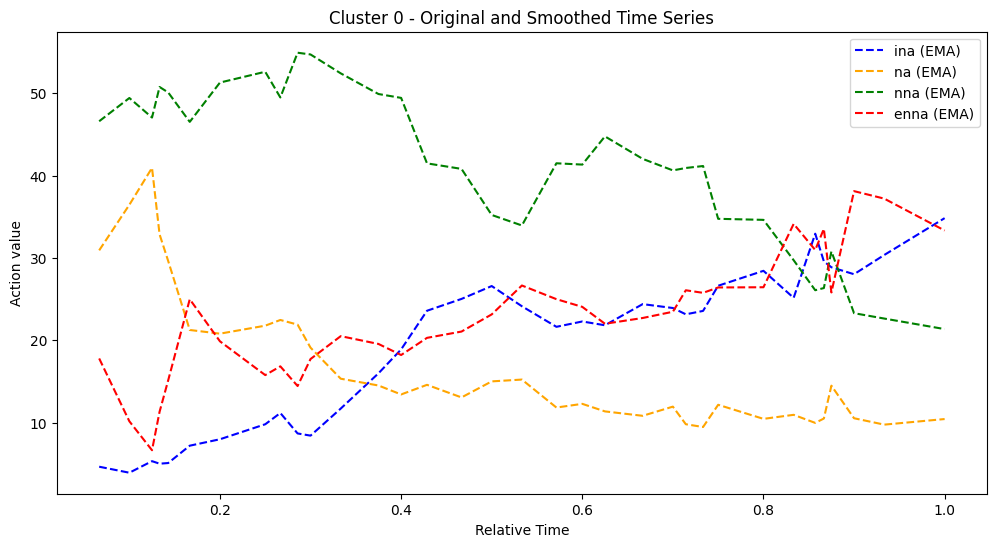

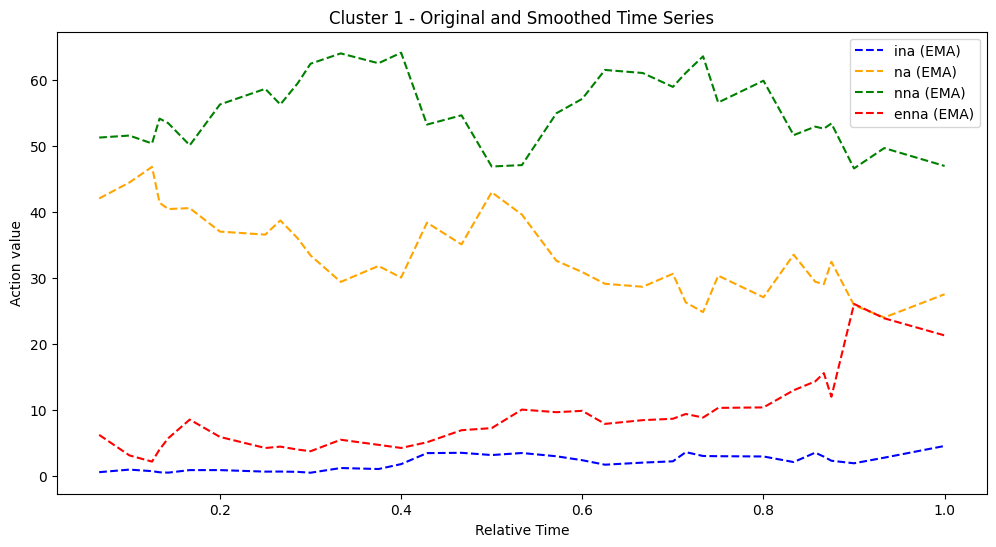

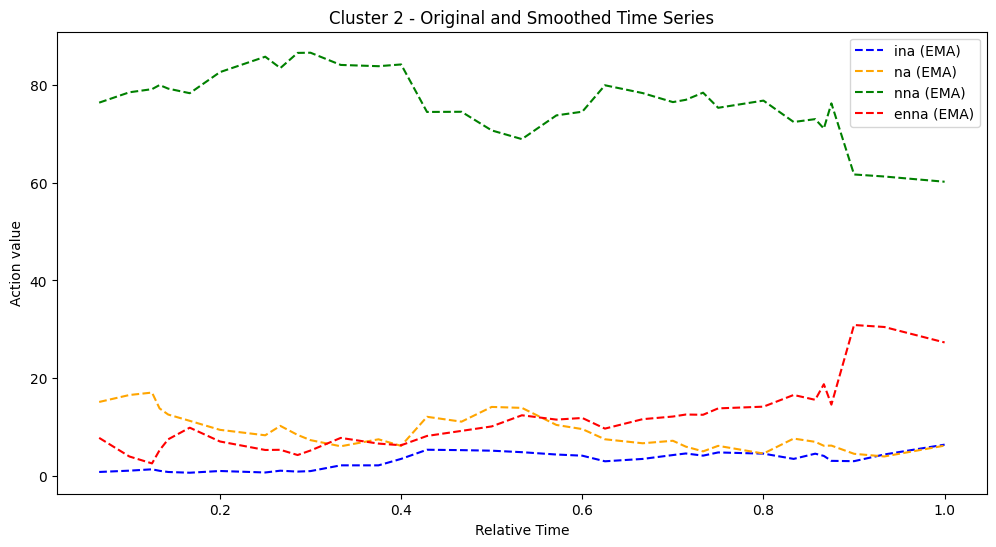

In [41]:
##### Plotting #####
import matplotlib.pyplot as plt

df['relative_time'] = df.groupby('ID')['time'].transform(lambda x: x / x.max())

n_clusters = 3
alpha = 0.3  # Smoothing factor for EMA
savgol_window = 3  # Window length for Savitzky-Golay filter
savgol_polyorder = 1  # Polynomial order for Savitzky-Golay filter

for cluster in range(n_clusters):
    cluster_data = df[df['cluster'] == cluster]
    mean_relative = cluster_data.groupby('relative_time')[['ina', 'na', 'nna', 'enna']].mean()
    mean_ilr_smooth_ema = mean_relative.apply(lambda x: x.ewm(alpha=alpha).mean())
    
    plt.figure(figsize=(12, 6))
    
    plt.plot(mean_relative.index, mean_ilr_smooth_ema["ina"], label="ina (EMA)", linestyle="--", color="blue")
    plt.plot(mean_relative.index, mean_ilr_smooth_ema["na"], label="na (EMA)", linestyle="--", color="orange")
    plt.plot(mean_relative.index, mean_ilr_smooth_ema["nna"], label="nna (EMA)", linestyle="--", color="green")
    plt.plot(mean_relative.index, mean_ilr_smooth_ema["enna"], label="enna (EMA)", linestyle="--", color="red")
    
    # Formatting the plot
    plt.xlabel("Relative Time")
    plt.ylabel("Action value")
    plt.title(f"Cluster {cluster} - Original and Smoothed Time Series")
    plt.legend()
    plt.show()


In [33]:
df['Experiment'] = df['Experiment'] + 1

In [103]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from torch.nn import functional as F

##############################
# Step 1: Load & Prepare Data
##############################

df = pd.read_csv("../data/data_ilr_transformed/combined_data.csv")
print(f"Combined dataset shape: {df.shape}")

# Assume there's an 'Experiment' column indicating the experiment number each participant belongs to
# Ensure 'Experiment' is categorical or integer
df['Experiment'] = df['Experiment'] - 1
df['Experiment'] = df['Experiment'].astype(int)  # or as needed
print("df['Experiment'].unique():", df['Experiment'].unique())

ilr_columns = ['ilr1', 'ilr2', 'ilr3']
control_columns = ['excluded', 'injustice', 'personal', 'violence']
covariate_columns = ['gender', 'age', 'condition']
ilr_resid_columns = ['ilr1_residual', 'ilr2_residual', 'ilr3_residual']

# Drop rows with NAs in covariates and standardize age
for covariate in covariate_columns:
    df = df[df[covariate].notna()]
df[['age']] = StandardScaler().fit_transform(df[['age']])

##### Feature Engineering (same as before) #####
df['relative_time'] = df.groupby('ID')['time'].transform(lambda x: x / x.max())

for col in ilr_columns:
    df[f'{col}_mean'] = df.groupby('ID')[col].transform('mean')
    df[f'{col}_std'] = df.groupby('ID')[col].transform('std')
    df[f'{col}_min'] = df.groupby('ID')[col].transform('min')
    df[f'{col}_max'] = df.groupby('ID')[col].transform('max')

window_size = 2
for col in ilr_columns:
    df[f'{col}_moving_avg'] = df.groupby('ID')[col].transform(lambda x: x.rolling(window=window_size, min_periods=1).mean())
    df[f'{col}_ema'] = df.groupby('ID')[col].transform(lambda x: x.ewm(span=window_size, adjust=False).mean())
# ilr_moving_avg_cols = ['ilr1_residual_moving_avg', 'ilr2_residual_moving_avg', 'ilr3_residual_moving_avg']
# ilr_ema_cols = ['ilr1_residual_ema', 'ilr2_residual_ema', 'ilr3_residual_ema']
ilr_moving_avg_cols = ['ilr1_moving_avg', 'ilr2_moving_avg', 'ilr3_moving_avg']
ilr_ema_cols = ['ilr1_ema', 'ilr2_ema', 'ilr3_ema']

# window_size = 3
# for col in ilr_columns:
#     df[f'{col}_moving_avg_ws3'] = df.groupby('ID')[col].transform(lambda x: x.rolling(window=window_size, min_periods=1).mean())
#     df[f'{col}_ema_ws3'] = df.groupby('ID')[col].transform(lambda x: x.ewm(span=window_size, adjust=False).mean())
# ilr_moving_avg_cols_ws3 = ['ilr1_residual_moving_avg_ws3', 'ilr2_residual_moving_avg_ws3', 'ilr3_residual_moving_avg_ws3']
# ilr_ema_cols_ws3 = ['ilr1_residual_ema_ws3', 'ilr2_residual_ema_ws3', 'ilr3_residual_ema_ws3']

fourier_components = 1
for column_group in [ilr_moving_avg_cols, 
                     ilr_ema_cols, 
                     # ilr_moving_avg_cols_ws3,
                     # ilr_ema_cols_ws3
                    ]:
    for col in column_group:
        def compute_fourier(x):
            fft_vals = np.fft.fft(x)
            return np.hstack([fft_vals.real[:fourier_components], fft_vals.imag[:fourier_components]])

        fourier_df = (
            df.groupby('ID')[col]
            .apply(lambda x: compute_fourier(x.values))
            .apply(pd.Series)
            .rename(columns=lambda i: f'{col}_fourier_{i+1}')
        )
        df = df.join(fourier_df, on='ID')

feature_columns = [
    # 'ilr1', 'ilr2', 'ilr3',

    'relative_time',

    'ilr1_mean', 'ilr2_mean', 'ilr3_mean',
    'ilr1_std', 'ilr2_std', 'ilr3_std',
    'ilr1_min', 'ilr2_min', 'ilr3_min',
    'ilr1_max', 'ilr2_max', 'ilr3_max',

    'ilr1_moving_avg_fourier_1', 'ilr2_moving_avg_fourier_1', 'ilr3_moving_avg_fourier_1',
    'ilr1_moving_avg_fourier_2', 'ilr2_moving_avg_fourier_2', 'ilr3_moving_avg_fourier_2',

    # 'ilr1_residual_mean', 'ilr2_residual_mean', 'ilr3_residual_mean',
    # 'ilr1_residual_std', 'ilr2_residual_std', 'ilr3_residual_std',
    # 'ilr1_residual_min', 'ilr2_residual_min', 'ilr3_residual_min',
    # 'ilr1_residual_max', 'ilr2_residual_max', 'ilr3_residual_max',

    # 'ilr1_residual_moving_avg_fourier_1', 'ilr2_residual_moving_avg_fourier_1', 'ilr3_residual_moving_avg_fourier_1',
    # 'ilr1_residual_moving_avg_fourier_2', 'ilr2_residual_moving_avg_fourier_2', 'ilr3_residual_moving_avg_fourier_2',
    # 'ilr1_residual_moving_avg_fourier_3', 'ilr2_residual_moving_avg_fourier_3', 'ilr3_residual_moving_avg_fourier_3',

    # 'ilr1_residual_ema_fourier_1', 'ilr2_residual_ema_fourier_1', 'ilr3_residual_ema_fourier_1',
    # 'ilr1_residual_ema_fourier_2', 'ilr2_residual_ema_fourier_2', 'ilr3_residual_ema_fourier_2',
    # 'ilr1_residual_ema_fourier_3', 'ilr2_residual_ema_fourier_3', 'ilr3_residual_ema_fourier_3',

    # 'ilr1_residual_moving_avg_ws3_fourier_1', 'ilr2_residual_moving_avg_ws3_fourier_1', 'ilr3_residual_moving_avg_ws3_fourier_1',
    # 'ilr1_residual_moving_avg_ws3_fourier_2', 'ilr2_residual_moving_avg_ws3_fourier_2', 'ilr3_residual_moving_avg_ws3_fourier_2',
    # 'ilr1_residual_moving_avg_ws3_fourier_3', 'ilr2_residual_moving_avg_ws3_fourier_3', 'ilr3_residual_moving_avg_ws3_fourier_3',
]

print(f"{len(feature_columns)} features used:")
print(feature_columns)

df = df.sort_values(by=['ID', 'time'])

# Extract experiment labels at the participant level
id_to_experiment = df.groupby('ID')['Experiment'].first().to_dict()

grouped = df.groupby('ID')
sequences = []
lengths = []
experiments = []

for pid, group in grouped:
    seq = group[feature_columns].values
    sequences.append(seq)
    lengths.append(len(seq))
    experiments.append(id_to_experiment[pid])

max_length = max(lengths)
num_features = len(feature_columns)
N = len(sequences)

padded_sequences = []
for seq in sequences:
    T = len(seq)
    if T < max_length:
        pad_mat = np.zeros((max_length - T, num_features))
        padded_seq = np.concatenate([seq, pad_mat], axis=0)
    else:
        padded_seq = seq
    padded_sequences.append(padded_seq)

padded_sequences = np.stack(padded_sequences, axis=0)
lengths = np.array(lengths)
experiments = np.array(experiments)  # domain labels

num_classes = len(np.unique(experiments))  # Number of experiments

##############################
# Step 3: Dataset with domain labels
##############################

class RadicalizationDataset(Dataset):
    def __init__(self, data, lengths, domains):
        self.data = torch.from_numpy(data).float()
        self.lengths = lengths
        self.domains = torch.from_numpy(domains).long()

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.lengths[idx], self.domains[idx]

dataset = RadicalizationDataset(padded_sequences, lengths, experiments)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

##############################
# Step 4: Gradient Reversal Layer
##############################

class GradientReversalFunction(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x, alpha):
        ctx.alpha = alpha
        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        # Reverse gradient by multiplying by -alpha
        return grad_output.neg().mul(ctx.alpha), None

class GradientReversalLayer(nn.Module):
    def __init__(self, alpha=1.0):
        super().__init__()
        self.alpha = alpha

    def forward(self, x):
        return GradientReversalFunction.apply(x, self.alpha)

##############################
# Step 5: Define the model with domain classifier
##############################

class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size=64, latent_size=32, num_layers=2, dropout=0.1):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, latent_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, lengths):
        sorted_lengths, indices = torch.sort(lengths, descending=True)
        x_sorted = x[indices]
        packed = nn.utils.rnn.pack_padded_sequence(x_sorted, sorted_lengths.cpu(), batch_first=True, enforce_sorted=True)
        _, (h, c) = self.lstm(packed)
        h = h[-1]  # Use the last layer's hidden state
        _, desort_indices = torch.sort(indices)
        h = h[desort_indices]
        latent = self.dropout(self.fc(h))  # Apply dropout after the fully connected layer
        return latent


class Decoder(nn.Module):
    def __init__(self, latent_size=32, hidden_size=64, output_size=3, num_layers=2, max_length=15, dropout=0.1):
        super().__init__()
        self.latent_to_hidden = nn.Linear(latent_size, hidden_size)
        self.lstm = nn.LSTM(output_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.output_layer = nn.Linear(hidden_size, output_size)
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.max_length = max_length
        self.dropout = nn.Dropout(dropout)

    def forward(self, latent):
        batch_size = latent.size(0)
        hidden = self.latent_to_hidden(latent).unsqueeze(0).repeat(self.num_layers, 1, 1)
        cell = torch.zeros(self.num_layers, batch_size, self.hidden_size, device=latent.device)
        inputs = torch.zeros(batch_size, self.max_length, 3, device=latent.device)
        output, (h, c) = self.lstm(inputs, (hidden, cell))
        reconstruction = self.dropout(self.output_layer(output))  # Apply dropout before the output layer
        return reconstruction


class DomainClassifier(nn.Module):
    def __init__(self, latent_size=32, num_classes=8):
        super().__init__()
        self.fc1 = nn.Linear(latent_size, 64)
        self.fc2 = nn.Linear(64, num_classes)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


class DA_LSTMAutoencoder(nn.Module):
    def __init__(self, input_size, hidden_size=64, latent_size=32, num_layers=2, max_length=15, num_classes=5, alpha=1.0):
        super().__init__()
        self.encoder = Encoder(input_size, hidden_size, latent_size, num_layers)
        self.decoder = Decoder(latent_size, hidden_size, output_size=3, num_layers=num_layers, max_length=max_length)
        self.grl = GradientReversalLayer(alpha=alpha)
        self.domain_classifier = DomainClassifier(latent_size, num_classes)

    def forward(self, x, lengths):
        latent = self.encoder(x, lengths)
        reconstruction = self.decoder(latent)
        
        # Domain classification with gradient reversal
        domain_output = self.domain_classifier(self.grl(latent))
        return reconstruction, latent, domain_output

model = DA_LSTMAutoencoder(
    input_size=num_features, 
    hidden_size=64, 
    latent_size=32, 
    num_layers=2, 
    max_length=max_length, 
    num_classes=num_classes, 
    alpha=1.0
)
model.to(device)

##############################
# Step 6: Train with Domain-Adversarial Loss
##############################

def train_da_autoencoder(model, dataloader, epochs=100, lr=1e-3, device='cpu', lambda_domain=1.0):
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
    reconstruction_criterion = nn.MSELoss()
    domain_criterion = nn.CrossEntropyLoss()

    model.train()
    for epoch in range(epochs):
        total_loss = 0.0
        for batch_x, batch_len, batch_dom in dataloader:
            batch_x, batch_len, batch_dom = batch_x.to(device), batch_len.to(device), batch_dom.to(device)
            
            reconstruction, latent, domain_out = model(batch_x, batch_len)

            # Reconstruction loss (only first 3 features if that's what we're reconstructing)
            recon_loss = reconstruction_criterion(reconstruction, batch_x[:, :, :3])
            # Domain loss
            domain_loss = domain_criterion(domain_out, batch_dom)

            # Total loss = recon_loss + ( -1 * domain_loss ) * handled by GRL 
            # With GRL, we just add them. The GRL layer negates the gradient for the encoder automatically.
            total = recon_loss + lambda_domain * domain_loss

            optimizer.zero_grad()
            total.backward()
            optimizer.step()

            total_loss += total.item() * batch_x.size(0)
        
        avg_loss = total_loss / len(dataloader.dataset)
        print(f"Epoch {epoch+1}/{epochs}, Total Loss: {avg_loss:.4f}")

    return model

trained_model = train_da_autoencoder(
    model, 
    dataloader, 
    epochs=200, 
    lr=0.001, 
    device=device, 
    lambda_domain=0.1
)

##############################
# Step 7: Extract Embeddings & Cluster
##############################

embeddings = []
trained_model.eval()
with torch.no_grad():
    for batch_x, batch_len, batch_dom in DataLoader(dataset, batch_size=32):
        batch_x, batch_len = batch_x.to(device), batch_len.to(device)
        _, latent, _ = trained_model(batch_x, batch_len)
        embeddings.append(latent.cpu().numpy())

embeddings = np.concatenate(embeddings, axis=0)

kmeans = KMeans(n_clusters=3, random_state=42)
cluster_labels = kmeans.fit_predict(embeddings)

Combined dataset shape: (19265, 18)
df['Experiment'].unique(): [0 1 2 3 4 5 6 7]
19 features used:
['relative_time', 'ilr1_mean', 'ilr2_mean', 'ilr3_mean', 'ilr1_std', 'ilr2_std', 'ilr3_std', 'ilr1_min', 'ilr2_min', 'ilr3_min', 'ilr1_max', 'ilr2_max', 'ilr3_max', 'ilr1_moving_avg_fourier_1', 'ilr2_moving_avg_fourier_1', 'ilr3_moving_avg_fourier_1', 'ilr1_moving_avg_fourier_2', 'ilr2_moving_avg_fourier_2', 'ilr3_moving_avg_fourier_2']
Epoch 1/200, Total Loss: 1.5106
Epoch 2/200, Total Loss: 0.9273
Epoch 3/200, Total Loss: 0.7280
Epoch 4/200, Total Loss: 0.5875
Epoch 5/200, Total Loss: 0.5612
Epoch 6/200, Total Loss: 0.5481
Epoch 7/200, Total Loss: 0.5264
Epoch 8/200, Total Loss: 0.5111
Epoch 9/200, Total Loss: 0.5361
Epoch 10/200, Total Loss: 0.4976
Epoch 11/200, Total Loss: 0.4942
Epoch 12/200, Total Loss: 0.5079
Epoch 13/200, Total Loss: 0.5281
Epoch 14/200, Total Loss: 0.4752
Epoch 15/200, Total Loss: 0.4674
Epoch 16/200, Total Loss: 0.4750
Epoch 17/200, Total Loss: 0.4912
Epoch 18/2

In [104]:
# Save embeddings to a CSV file
import pandas as pd

embeddings_df = pd.DataFrame(embeddings)
embeddings_df.to_csv("embeddings.csv", index=False)

# Alternatively, save as a NumPy file
np.save("embeddings.npy", embeddings)

In [105]:
# Attach clusters back to df if needed
unique_ids = df['ID'].unique()
df_clusters = pd.DataFrame({'ID': unique_ids, 'cluster': cluster_labels})
df = df.merge(df_clusters, on='ID', how='left')


# Create a summary of the number of participants from each experiment within each cluster
experiment_cluster_summary = df.groupby(['cluster', 'Experiment']).size().unstack(fill_value=0)

# Display the summary table
print(experiment_cluster_summary)

Experiment     0    1     2     3     4     5     6    7
cluster                                                 
0           1095  885  1035  3225  3060  2040  1295  684
1            105  150    45   300   170    72   245   42
2           1155  450   585  1965   100    24    91   18


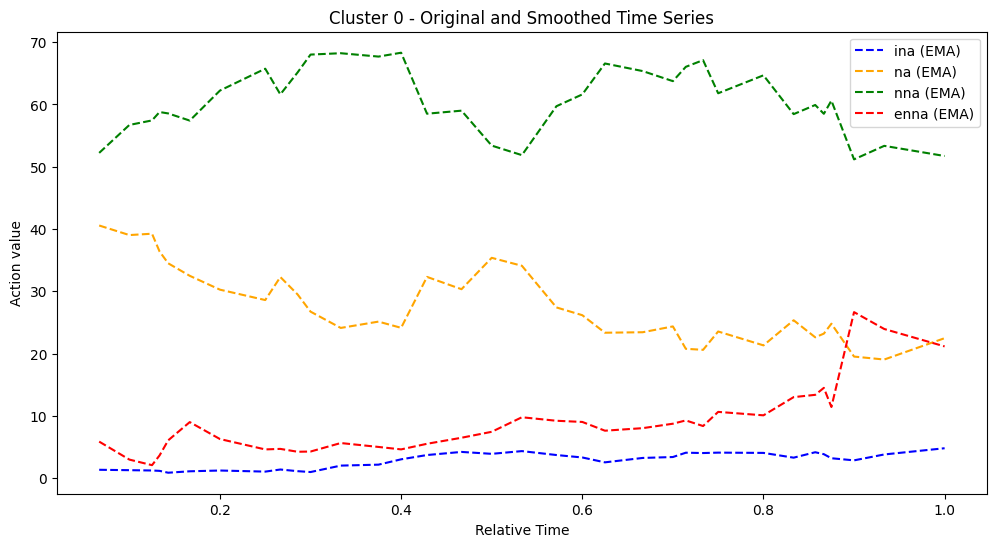

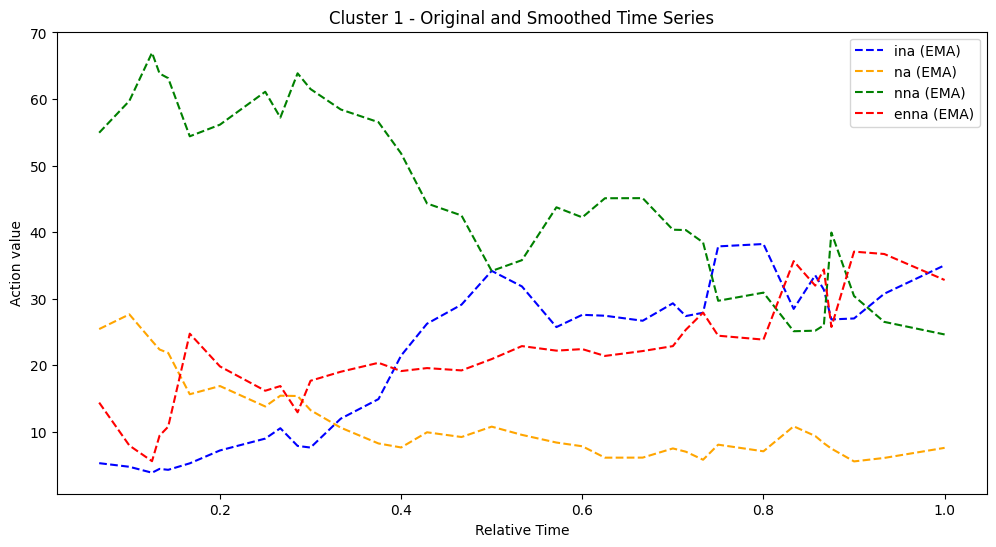

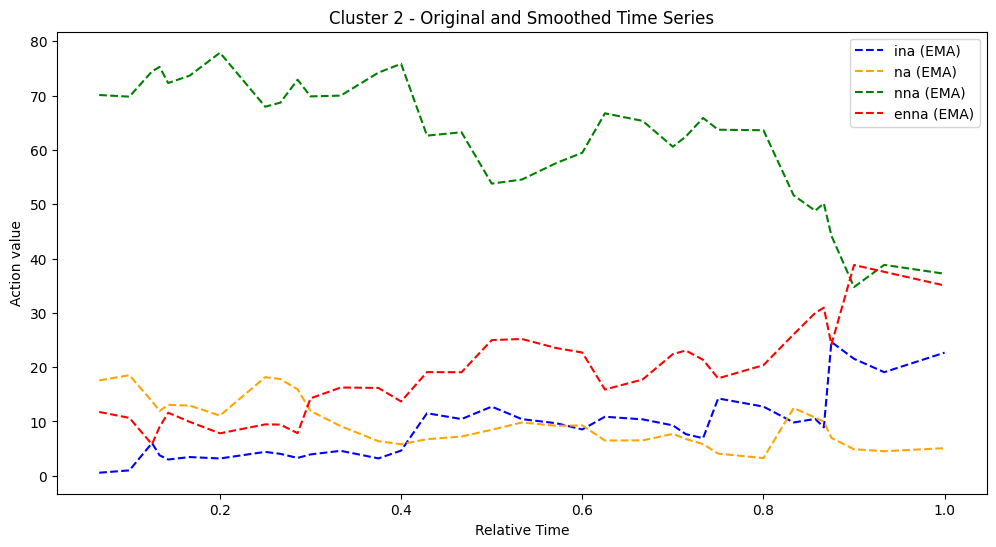

In [106]:
##### Plotting #####
import matplotlib.pyplot as plt

df['relative_time'] = df.groupby('ID')['time'].transform(lambda x: x / x.max())

n_clusters = 3
alpha = 0.3  # Smoothing factor for EMA
savgol_window = 3  # Window length for Savitzky-Golay filter
savgol_polyorder = 1  # Polynomial order for Savitzky-Golay filter

for cluster in range(n_clusters):
    cluster_data = df[df['cluster'] == cluster]
    mean_relative = cluster_data.groupby('relative_time')[['ina', 'na', 'nna', 'enna']].mean()
    mean_ilr_smooth_ema = mean_relative.apply(lambda x: x.ewm(alpha=alpha).mean())
    
    plt.figure(figsize=(12, 6))
    
    plt.plot(mean_relative.index, mean_ilr_smooth_ema["ina"], label="ina (EMA)", linestyle="--", color="blue")
    plt.plot(mean_relative.index, mean_ilr_smooth_ema["na"], label="na (EMA)", linestyle="--", color="orange")
    plt.plot(mean_relative.index, mean_ilr_smooth_ema["nna"], label="nna (EMA)", linestyle="--", color="green")
    plt.plot(mean_relative.index, mean_ilr_smooth_ema["enna"], label="enna (EMA)", linestyle="--", color="red")
    
    # Formatting the plot
    plt.xlabel("Relative Time")
    plt.ylabel("Action value")
    plt.title(f"Cluster {cluster} - Original and Smoothed Time Series")
    plt.legend()
    plt.show()


In [107]:
from sklearn.metrics import silhouette_score

sil_score = silhouette_score(embeddings, cluster_labels)
print(f"Silhouette Score: {sil_score:.4f}")

from sklearn.metrics import calinski_harabasz_score

ch_score = calinski_harabasz_score(embeddings, cluster_labels)
print(f"Calinski-Harabasz Score: {ch_score:.4f}")

from sklearn.metrics import davies_bouldin_score

db_score = davies_bouldin_score(embeddings, cluster_labels)
print(f"Davies-Bouldin Score: {db_score:.4f}")


Silhouette Score: 0.5759
Calinski-Harabasz Score: 1895.5124
Davies-Bouldin Score: 0.7048


In [ ]:
# Create participant-level masks
participant_ids = np.array(list(grouped.groups.keys()))  # Unique participant IDs
participant_experiments = np.array([id_to_experiment[pid] for pid in participant_ids])  # Experiment labels for each participant

# LOEO Validation Loop
experiments = np.unique(participant_experiments)
results = []

all_embeddings = []

for test_experiment in experiments:
    print(f"Leave-One-Experiment-Out Validation: Test on Experiment {test_experiment + 1}")
    
    # Create participant-level masks
    train_mask = participant_experiments != test_experiment
    test_mask = participant_experiments == test_experiment
    
    # Apply masks to participant-level arrays
    train_data = padded_sequences[train_mask]
    train_lengths = lengths[train_mask]
    train_domains = participant_experiments[train_mask]
    
    test_data = padded_sequences[test_mask]
    test_lengths = lengths[test_mask]
    test_domains = participant_experiments[test_mask]
    
    # Create Datasets and Dataloaders
    train_dataset = RadicalizationDataset(train_data, train_lengths, train_domains)
    test_dataset = RadicalizationDataset(test_data, test_lengths, test_domains)
    
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
    
    # Initialize and Train Model
    model = DA_LSTMAutoencoder(
        input_size=num_features,
        hidden_size=64,
        latent_size=32,
        num_layers=2,
        max_length=max_length,
        num_classes=num_classes,
        alpha=1.0
    )
    model.to(device)
    model = train_da_autoencoder(model, train_loader, epochs=50, lr=1e-3, device=device, lambda_domain=0.1)
    
    # Evaluate on Test Set
    model.eval()
    total_reconstruction_loss = 0.0
    total_domain_accuracy = 0.0
    total_samples = 0
    
    embeddings = []

    with torch.no_grad():
        for batch_x, batch_len, batch_dom in test_loader:
            batch_x, batch_len, batch_dom = batch_x.to(device), batch_len.to(device), batch_dom.to(device)
            
            reconstruction, latent, domain_out = model(batch_x, batch_len)
            
            # Reconstruction Loss
            recon_loss = nn.MSELoss()(reconstruction, batch_x[:, :, :3])
            total_reconstruction_loss += recon_loss.item() * batch_x.size(0)
            
            # Domain Classification Accuracy
            predicted_domains = domain_out.argmax(dim=1)
            domain_accuracy = (predicted_domains == batch_dom).float().mean().item()
            total_domain_accuracy += domain_accuracy * batch_x.size(0)
            
            total_samples += batch_x.size(0)

            embeddings.append(latent.cpu().numpy())

    all_embeddings.append(np.concatenate(embeddings, axis=0))

    avg_reconstruction_loss = total_reconstruction_loss / total_samples
    avg_domain_accuracy = total_domain_accuracy / total_samples
    
    print(f"Test Experiment {test_experiment + 1}:")
    print(f"  Reconstruction Loss: {avg_reconstruction_loss:.4f}")
    print(f"  Domain Accuracy: {avg_domain_accuracy:.4f}")
    
    results.append({
        "test_experiment": test_experiment + 1,
        "reconstruction_loss": avg_reconstruction_loss,
        "domain_accuracy": avg_domain_accuracy
    })

# Aggregate Results
results_df = pd.DataFrame(results)
print("LOEO Validation Results:")
print(results_df)
print(f"Average Reconstruction Loss: {results_df['reconstruction_loss'].mean():.4f}")
print(f"Average Domain Accuracy: {results_df['domain_accuracy'].mean():.4f}")


Leave-One-Experiment-Out Validation: Test on Experiment 1
Epoch 1/50, Total Loss: 1.3491
Epoch 2/50, Total Loss: 0.8198
Epoch 3/50, Total Loss: 0.6436
Epoch 4/50, Total Loss: 0.4621
Epoch 5/50, Total Loss: 0.3564
Epoch 6/50, Total Loss: 0.3271
Epoch 7/50, Total Loss: 0.3220
Epoch 8/50, Total Loss: 0.2974
Epoch 9/50, Total Loss: 0.2941
Epoch 10/50, Total Loss: 0.2802
Epoch 11/50, Total Loss: 0.2703
Epoch 12/50, Total Loss: 0.2245
Epoch 13/50, Total Loss: 0.2465
Epoch 14/50, Total Loss: 0.2144
Epoch 15/50, Total Loss: 0.1788
Epoch 16/50, Total Loss: 0.2287
Epoch 17/50, Total Loss: 0.2396
Epoch 18/50, Total Loss: 0.2023
Epoch 19/50, Total Loss: 0.2178
Epoch 20/50, Total Loss: 0.2640
Epoch 21/50, Total Loss: 0.2157
Epoch 22/50, Total Loss: 0.1843
Epoch 23/50, Total Loss: 0.2118
Epoch 24/50, Total Loss: 0.1850
Epoch 25/50, Total Loss: 0.1726
Epoch 26/50, Total Loss: 0.1906
Epoch 27/50, Total Loss: 0.1847
Epoch 28/50, Total Loss: 0.2020
Epoch 29/50, Total Loss: 0.1676
Epoch 30/50, Total Loss

In [ ]:
# Convert to numpy array for easier manipulation
all_embeddings = np.stack(all_embeddings, axis=0)  # Shape: (num_models, num_participants, latent_size)

# Option 1: Average embeddings
ensemble_embeddings = np.mean(all_embeddings, axis=0)  # Shape: (num_participants, latent_size)

# Option 2: Concatenate embeddings
ensemble_embeddings = all_embeddings.transpose(1, 0, 2).reshape(all_embeddings.shape[1], -1)  # Shape: (num_participants, num_models * latent_size)


In [ ]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3, random_state=42)
cluster_labels = kmeans.fit_predict(ensemble_embeddings)

# Add cluster labels to your original dataframe for analysis
df['cluster'] = cluster_labels

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Reduce embeddings to 2D for visualization
tsne = TSNE(n_components=2, random_state=42)
reduced_embeddings = tsne.fit_transform(ensemble_embeddings)

# Plot clusters
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=cluster_labels, cmap='viridis', s=10)
plt.colorbar(label="Cluster")
plt.title("Cluster Visualization (t-SNE)")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.show()